# Proyek Klasifikasi Gambar: Rice & Random Image Dataset
- **Nama:** Jessica Theresia
- **Email:** me.jessicatheresia@gmail.com
- **ID Dicoding:** jessica_trs
- **Sumber Dataset:**
  1. https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
  2. https://www.kaggle.com/datasets/shamsaddin97/image-captioning-dataset-random-images

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [2]:
!pip install scikit-image

In [3]:
!pip install opencv-python-headless

In [4]:
!pip install gdown

In [5]:
import gdown
import zipfile
import os
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from skimage import img_as_ubyte
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-04-21 10:51:34.734880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745232694.934261      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745232694.989619      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

### Data Loading

In [6]:
file_id = "1BBpGevd9gWmTJICxk7nqXaIODEKlKZco"
output = "Dataset Klasifikasi Gambar.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Ekstrak file ZIP
extract_dir = "dataset"
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Set path hasil ekstraksi
EXTRACTED_PATH = os.path.join(os.getcwd(), extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1BBpGevd9gWmTJICxk7nqXaIODEKlKZco
From (redirected): https://drive.google.com/uc?id=1BBpGevd9gWmTJICxk7nqXaIODEKlKZco&confirm=t&uuid=594c301b-ad4d-45ad-8099-279f80adf7af
To: /kaggle/working/Dataset Klasifikasi Gambar.zip
100%|██████████| 265M/265M [00:01<00:00, 251MB/s] 


#### Dataset Checking

Dataset berjumlah 77.046 data, terdiri dari gabungan data lima jenis beras yang berbeda, ditambah dengan dataset gambar acak (random). Penambahan gambar acak bertujuan agar model dapat membedakan antara gambar beras yang termasuk ke dalam lima kategori yang telah dipelajari, dengan gambar lain yang tidak termasuk jenis beras tersebut, sehingga dapat diklasifikasikan sebagai kelas unknown.

In [7]:
subdirs = [d for d in os.listdir(EXTRACTED_PATH) if os.path.isdir(os.path.join(EXTRACTED_PATH, d))]
if len(subdirs) == 1:
    EXTRACTED_PATH = os.path.join(EXTRACTED_PATH, subdirs[0])
    
classes = [d for d in os.listdir(EXTRACTED_PATH) if os.path.isdir(os.path.join(EXTRACTED_PATH, d))]
print("Kelas yang ditemukan:", classes)

Kelas yang ditemukan: ['Basmati', 'Ipsala', 'Arborio', 'Jasmine', 'Karacadag', 'Unknown']


** Menampilkan jumlah dan resolusi gambar per kelas

In [8]:
def print_images_resolution(directory):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        unique_sizes = set()
        num_images = len(image_files)
        print(f"\n{subdir}: {num_images} gambar")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except:
                print(f"Gagal membaca gambar: {img_file}")

        for size in unique_sizes:
            print(f"- Resolusi: {size}")
        print("---------------")

In [9]:
print_images_resolution(EXTRACTED_PATH)


Basmati: 15000 gambar
- Resolusi: (250, 250)
---------------

Ipsala: 15000 gambar
- Resolusi: (250, 250)
---------------

Arborio: 15000 gambar
- Resolusi: (250, 250)
---------------

Jasmine: 15000 gambar
- Resolusi: (250, 250)
---------------

Karacadag: 15000 gambar
- Resolusi: (250, 250)
---------------

Unknown: 2046 gambar
- Resolusi: (247, 255)
- Resolusi: (258, 255)
- Resolusi: (269, 255)
- Resolusi: (376, 256)
- Resolusi: (415, 256)
- Resolusi: (220, 255)
- Resolusi: (338, 256)
- Resolusi: (483, 256)
- Resolusi: (243, 256)
- Resolusi: (232, 256)
- Resolusi: (433, 255)
- Resolusi: (171, 255)
- Resolusi: (182, 255)
- Resolusi: (612, 235)
- Resolusi: (445, 256)
- Resolusi: (183, 256)
- Resolusi: (194, 256)
- Resolusi: (384, 255)
- Resolusi: (278, 255)
- Resolusi: (289, 255)
- Resolusi: (513, 256)
- Resolusi: (251, 256)
- Resolusi: (156, 256)
- Resolusi: (122, 254)
- Resolusi: (145, 256)
- Resolusi: (398, 256)
- Resolusi: (240, 255)
- Resolusi: (163, 255)
- Resolusi: (297, 255)


Dataset preview

In [10]:
def show_dataset_samples(base_path, classes, samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2.2, len(classes) * 2.5))

    for row_idx, cls in enumerate(classes):
        class_path = os.path.join(base_path, cls)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        selected_images = random.sample(images, min(samples_per_class, len(images)))

        for col_idx, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))

            idx = row_idx * samples_per_class + col_idx + 1
            plt.subplot(len(classes), samples_per_class, idx)
            plt.imshow(img)
            plt.axis('off')

            # Tampilkan nama kelas di kolom pertama
            if col_idx == 0:
                plt.title(cls, fontsize=10, loc='left', pad=10)

    plt.suptitle("Contoh Gambar per Kelas", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

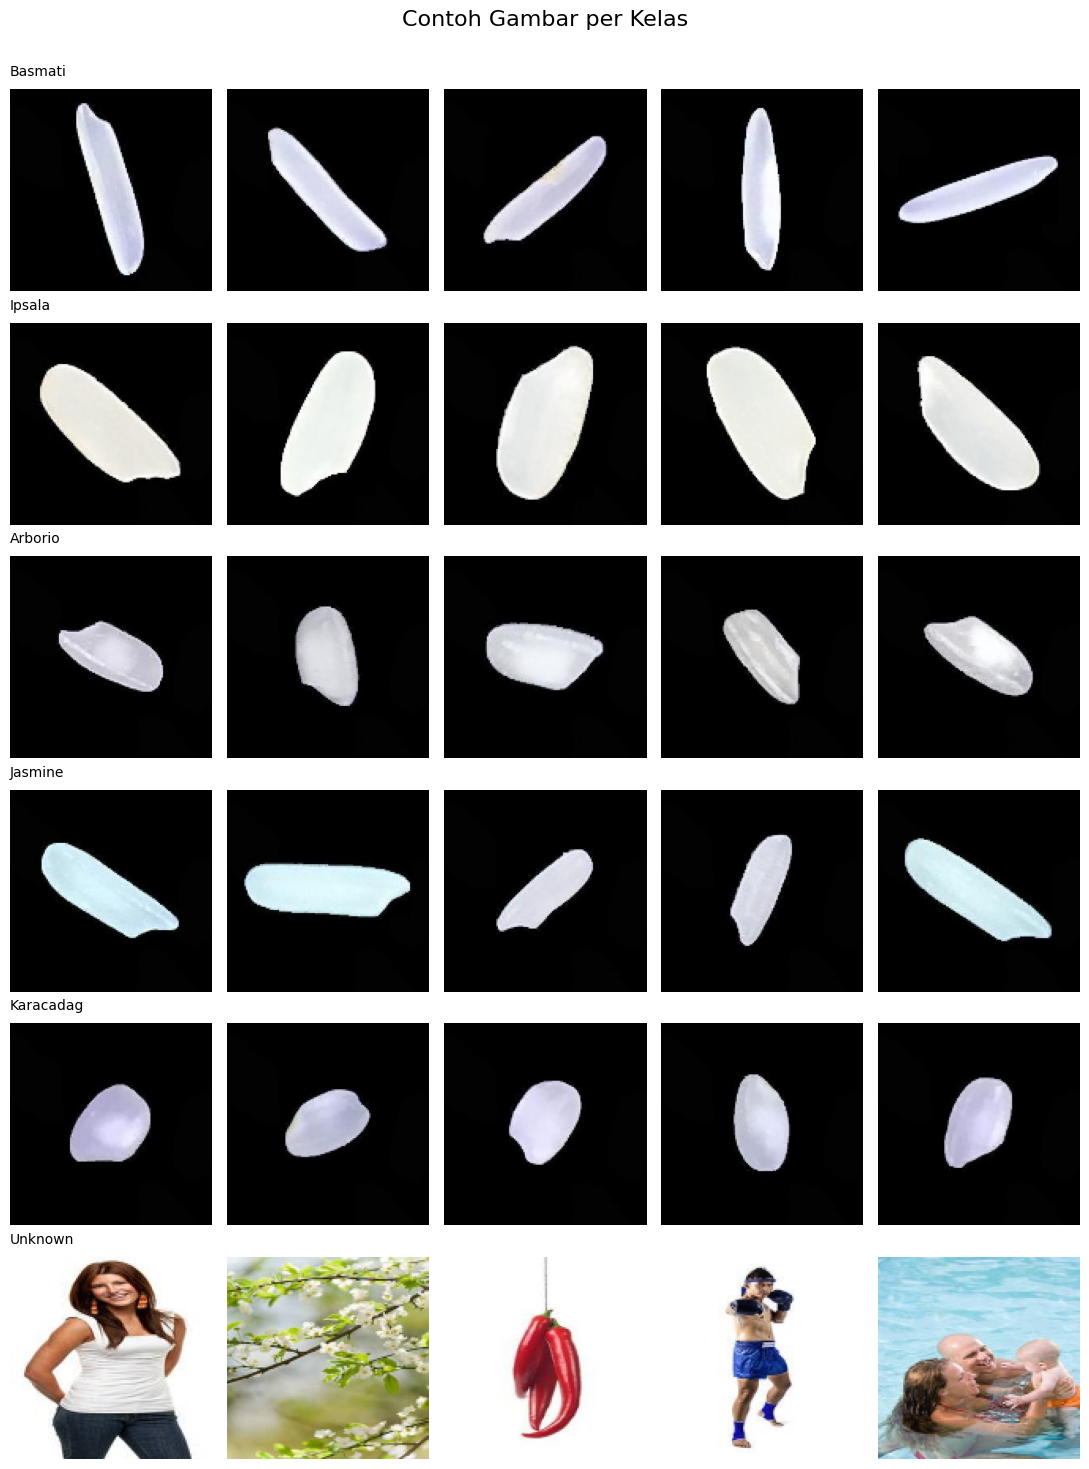

In [11]:
show_dataset_samples(EXTRACTED_PATH, classes, samples_per_class=5)

#### Plot Distribusi Data

In [12]:
# Hitung jumlah gambar per kelas
class_counts = {}
for cls in classes:
    class_path = os.path.join(EXTRACTED_PATH, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

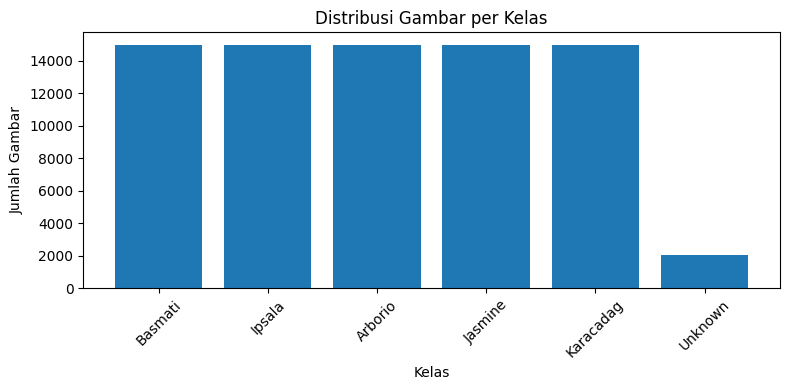

In [13]:
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dapat dilihat bahwa kelas unknown memiliki resolusi gambar yang tidak seragam serta jumlah data yang terbatas tanpa variasi bentuk. Oleh karena itu, diperlukan proses resize dan augmentasi yang lebih kompleks pada kelas unknown agar model dapat mengenali pola dengan lebih baik serta menghindari bias selama pelatihan. Selain itu, teknik oversampling juga perlu diterapkan untuk menyeimbangkan jumlah data pada kelas unknown agar setara dengan kelas beras lainnya.

### Data Preprocessing

#### Data Augmentasi

In [14]:
# Parameter
AUGMENTED_PATH = "/kaggle/working/Dataset_Klasifikasi_Gambar/image_augmented"
IMAGES_PER_CLASS = 15000
TARGET_SIZE = (224, 224)

In [15]:
# Semua transformasi
def anticlockwise_rotation(img): return rotate(resize_image(img), random.randint(0, 180))
def clockwise_rotation(img): return rotate(resize_image(img), -random.randint(0, 180))
def flip_up_down(img): return np.flipud(resize_image(img))
def add_brightness(img): return adjust_gamma(resize_image(img), gamma=0.5)
def blur_image(img): return cv2.GaussianBlur(resize_image(img), (9, 9), 0)
def sheared(img): return warp(resize_image(img), AffineTransform(shear=0.2), mode="wrap")
def warp_shift(img): return warp(resize_image(img), AffineTransform(translation=(0, 40)), mode="wrap")

# Transformasi untuk unknown
transformations_unknown = {
    'anticlockwise': anticlockwise_rotation,
    'clockwise': clockwise_rotation,
    'flip': flip_up_down,
    'bright': add_brightness,
    'blur': blur_image,
    'shear': sheared,
    'warp': warp_shift
}

# Transformasi umum untuk kelas selain unknown
transformations_general = {
    'bright': add_brightness,
    'blur': blur_image,
    'shear': sheared,
    'warp': warp_shift
}

In [16]:
def resize_image(img, target_size=TARGET_SIZE):
    return cv2.resize(img, target_size)

In [17]:
def copy_and_resize_images(src, dst, images):
    """Menyalin dan resize gambar asli"""
    for idx, img_name in enumerate(images):
        img = cv2.imread(os.path.join(src, img_name))
        if img is None:
            continue
        resized = resize_image(img)
        cv2.imwrite(os.path.join(dst, f"ori_{idx+1}.jpg"), resized)

In [18]:
def augment_image(img, label):
    """Augmentasi gambar sesuai label"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if label.lower().strip() == "unknown":
        augmented_images = []
        for name, transform in transformations_unknown.items():
            aug = transform(img_rgb)
            out = img_as_ubyte(aug)
            out_bgr = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
            augmented_images.append((name, out_bgr))
        return augmented_images
    else:
        aug = random.choice(list(transformations_general.values()))(img_rgb)
        out = img_as_ubyte(aug)
        out_bgr = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
        return [("random", out_bgr)]

In [19]:
def oversample_class(cls, src, dst, images, total_original, target_count=IMAGES_PER_CLASS):
    """Fungsi untuk oversampling kelas tertentu"""
    oversampled_count = 0
    for i in tqdm(range(target_count - total_original), desc=f"Oversampling {cls}"):
        img = cv2.imread(os.path.join(src, random.choice(images)))
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for _ in range(random.randint(1, 3)):
            img_rgb = random.choice(list(transformations_general.values()))(img_rgb)
        out = img_as_ubyte(img_rgb)
        out_bgr = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dst, f"os_{i+1}.jpg"), out_bgr)
        oversampled_count += 1
    return oversampled_count

In [20]:
def augment_and_oversample():
    """Proses augmentasi dan oversampling"""
    os.makedirs(AUGMENTED_PATH, exist_ok=True)
    classes = [cls for cls in os.listdir(EXTRACTED_PATH) if os.path.isdir(os.path.join(EXTRACTED_PATH, cls))]

    print("...Proses augmentasi dan oversampling...\n")

    for cls in classes:
        print(f"Kelas: {cls}")
        src = os.path.join(EXTRACTED_PATH, cls)
        dst = os.path.join(AUGMENTED_PATH, cls)
        os.makedirs(dst, exist_ok=True)

        images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_original = len(images)

        copy_and_resize_images(src, dst, images)

        # Augmentasi
        augment_count = 0
        for img_name in tqdm(images, desc=f"Augmentasi {cls}"):
            img = cv2.imread(os.path.join(src, img_name))
            if img is None:
                continue
            augmented_images = augment_image(img, cls)

            for i, (transform_name, augmented_image) in enumerate(augmented_images):
                filename = (
                    f"{transform_name}_{i+1}_{img_name}" if cls.lower().strip() == "unknown"
                    else f"aug_{random.randint(1, 10000)}_{img_name}"
                )
                cv2.imwrite(os.path.join(dst, filename), augmented_image)
                augment_count += 1

        # Oversampling untuk unknown
        oversampled_count = 0
        if cls.lower().strip() == "unknown":
            oversampled_count = oversample_class(cls, src, dst, images, total_original)

        print(f"{cls} - Asli: {total_original}, Augmentasi: {augment_count}, Oversampling: {oversampled_count}\n")

    print("Proses augmentasi dan oversampling selesai!")

In [21]:
augment_and_oversample()

...Proses augmentasi dan oversampling...

Kelas: Basmati


Augmentasi Basmati: 100%|██████████| 15000/15000 [01:02<00:00, 240.87it/s]


Basmati - Asli: 15000, Augmentasi: 15000, Oversampling: 0

Kelas: Ipsala


Augmentasi Ipsala: 100%|██████████| 15000/15000 [01:02<00:00, 238.98it/s]


Ipsala - Asli: 15000, Augmentasi: 15000, Oversampling: 0

Kelas: Arborio


Augmentasi Arborio: 100%|██████████| 15000/15000 [01:01<00:00, 243.50it/s]


Arborio - Asli: 15000, Augmentasi: 15000, Oversampling: 0

Kelas: Jasmine


Augmentasi Jasmine: 100%|██████████| 15000/15000 [01:01<00:00, 244.11it/s]


Jasmine - Asli: 15000, Augmentasi: 15000, Oversampling: 0

Kelas: Karacadag


Augmentasi Karacadag: 100%|██████████| 15000/15000 [01:01<00:00, 245.32it/s]


Karacadag - Asli: 15000, Augmentasi: 15000, Oversampling: 0

Kelas: Unknown


Oversampling Unknown: 100%|██████████| 12954/12954 [01:41<00:00, 127.01it/s]

Unknown - Asli: 2046, Augmentasi: 14322, Oversampling: 12954

Proses augmentasi dan oversampling selesai!


** Hasil Augmentasi

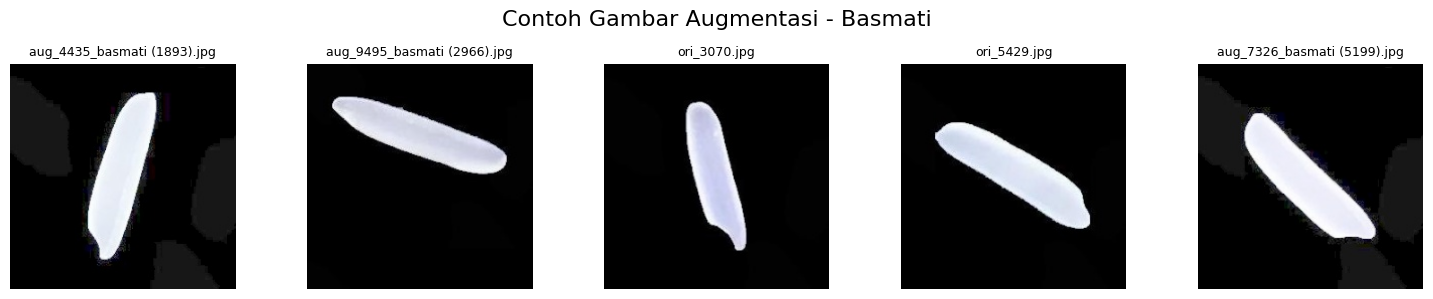

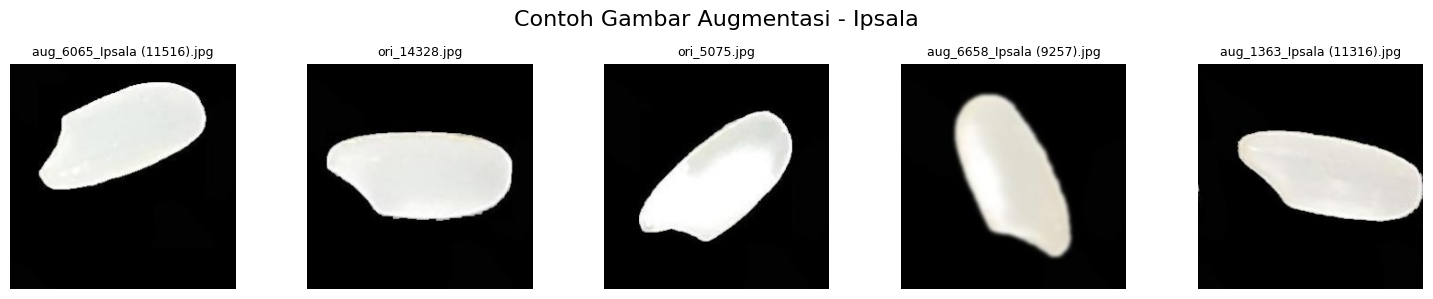

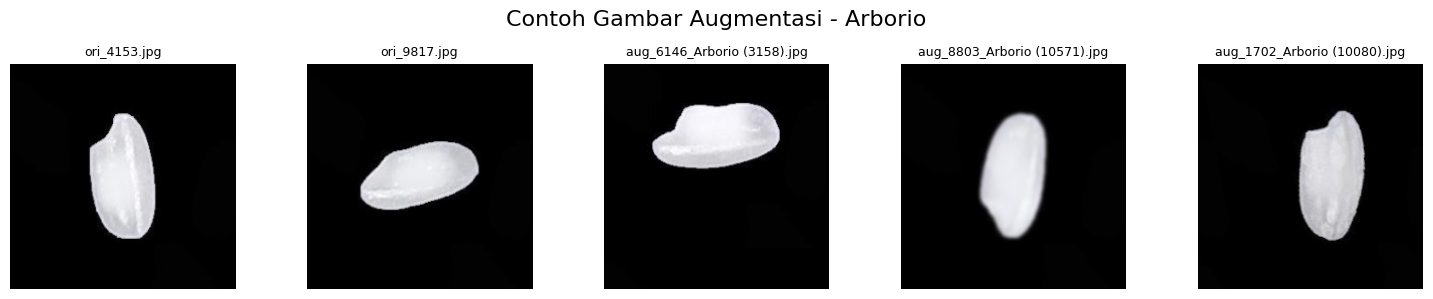

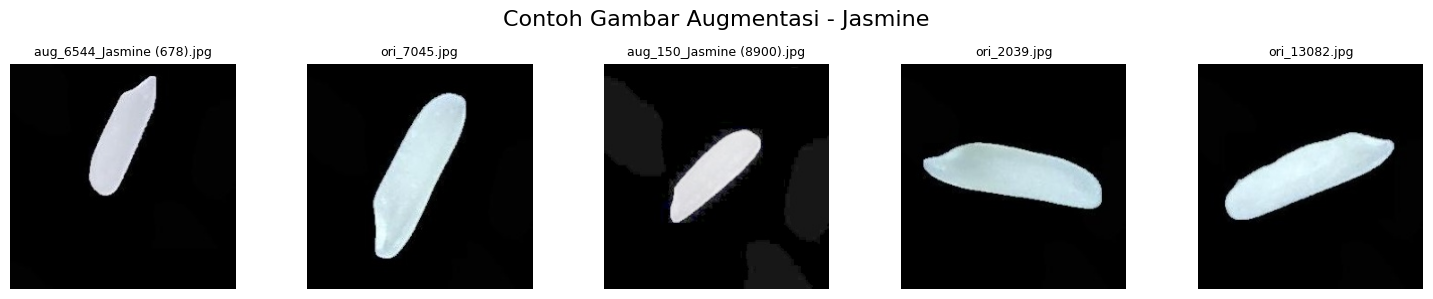

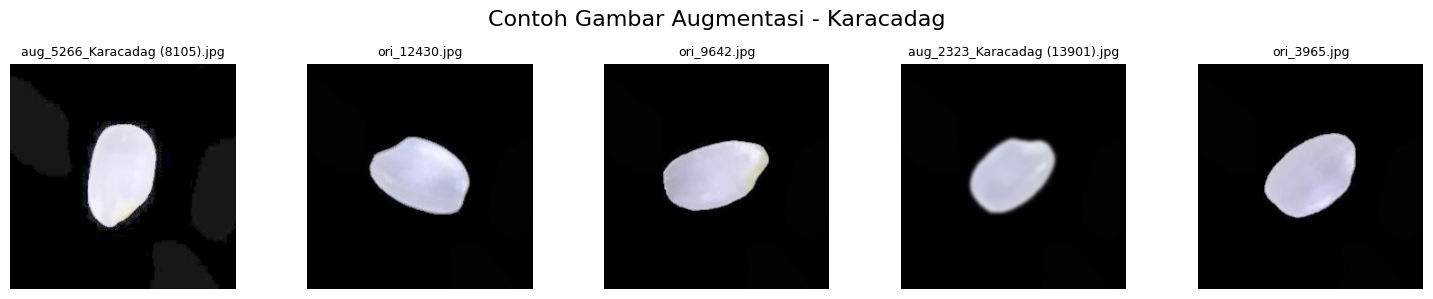

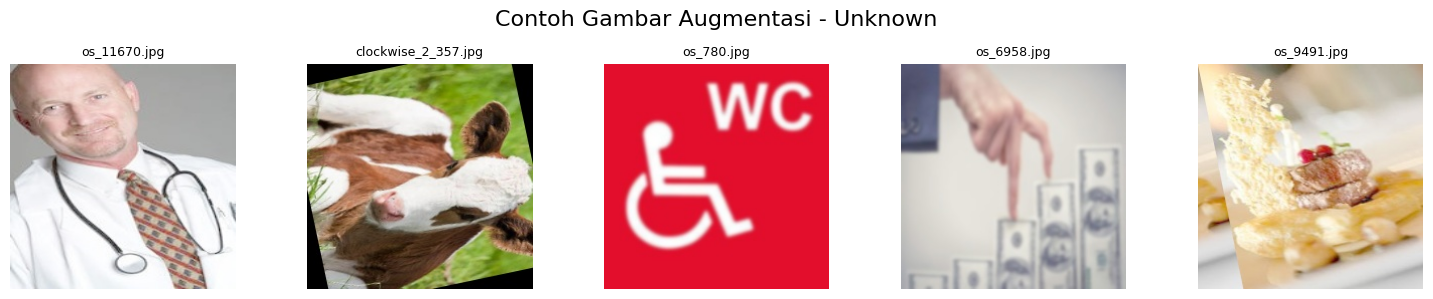

In [22]:
classes = [cls for cls in os.listdir(AUGMENTED_PATH) if os.path.isdir(os.path.join(AUGMENTED_PATH, cls))]

for cls in classes:
    aug_folder = os.path.join(AUGMENTED_PATH, cls)
    all_images = [img for img in os.listdir(aug_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) < 5:
        print(f"Jumlah gambar di kelas {cls} kurang dari 5. Menampilkan {len(all_images)} gambar.")
    sample_images = random.sample(all_images, min(5, len(all_images)))

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Contoh Gambar Augmentasi - {cls}", fontsize=16)

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(aug_folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"{img_name}", fontsize=9)

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()

In [23]:
# file ZIP untuk dataset augmentasi
zip_filename_augmented = "/kaggle/working/Dataset_Klasifikasi_Gambar/image_augmented/image_augmented.zip"

shutil.make_archive(zip_filename_augmented.replace('.zip', ''), 'zip', AUGMENTED_PATH)

print(f"File ZIP untuk dataset augmentasi berhasil dibuat: {zip_filename_augmented}")

File ZIP untuk dataset augmentasi berhasil dibuat: /kaggle/working/Dataset_Klasifikasi_Gambar/image_augmented/image_augmented.zip


#### Split Dataset

Dataset dibagi menjadi 80% training dan 20% testing.

In [24]:
SPLIT_PATH = '/kaggle/working/Dataset_Klasifikasi_Gambar/split_dataset'
SEED = 42

In [25]:
file_name, labels, full_path = [], [], []
for path, subdirs, files in os.walk(AUGMENTED_PATH):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})
X_train, X_test, y_train, y_test = train_test_split(df['path'], df['labels'], test_size=0.2, random_state=SEED, stratify=df['labels'])

df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test  = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_all   = pd.concat([df_train, df_test], ignore_index=True)

In [26]:
for _, row in tqdm(df_all.iterrows(), total=len(df_all)):
    src = row['path']
    dst = os.path.join(SPLIT_PATH, row['set'], row['labels'])
    os.makedirs(dst, exist_ok=True)
    shutil.copy2(src, os.path.join(dst, os.path.basename(src)))

100%|██████████| 179322/179322 [00:42<00:00, 4241.45it/s]


In [27]:
print("\n Distribusi Data per Kelas:")
for class_name in sorted(df['labels'].unique()):
    total = df[df['labels'] == class_name].shape[0]
    train = df_train[df_train['labels'] == class_name].shape[0]
    test = df_test[df_test['labels'] == class_name].shape[0]
    print(f"[✓] Kelas {class_name} – Total: {total}, Train: {train}, Test: {test}")


 Distribusi Data per Kelas:
[✓] Kelas Arborio – Total: 30000, Train: 24000, Test: 6000
[✓] Kelas Basmati – Total: 30000, Train: 24000, Test: 6000
[✓] Kelas Ipsala – Total: 30000, Train: 24000, Test: 6000
[✓] Kelas Jasmine – Total: 30000, Train: 24000, Test: 6000
[✓] Kelas Karacadag – Total: 30000, Train: 24000, Test: 6000
[✓] Kelas Unknown – Total: 29322, Train: 23457, Test: 5865


In [28]:
# File ZIP untuk Dataset Split
zip_filename_split = "/kaggle/working/Dataset_Klasifikasi_Gambar/split_dataset/split_dataset.zip"

shutil.make_archive(zip_filename_split.replace('.zip', ''), 'zip', SPLIT_PATH)

print(f"File ZIP untuk dataset augmentasi berhasil dibuat: {zip_filename_split}")

File ZIP untuk dataset augmentasi berhasil dibuat: /kaggle/working/Dataset_Klasifikasi_Gambar/split_dataset/split_dataset.zip


#### Image Data Generator

Pada tahap ini dilakukan image data generator dengan penambahan beberapa augmentasi serta membagi data train dan validation.

ImageDataGenerator dan Pembagian Subset:

1. Pada **train_datagen dan val_datagen**, terdapat parameter validation_split=0.2. Ini mengatur pembagian dataset menjadi dua bagian yaitu 80% untuk data pelatihan (training), dan 20% untuk data validasi (validation).

2. **validation_split** menentukan berapa persen dari dataset yang akan digunakan untuk validasi. Dalam hal ini, pembagian data untuk validation diambil 20% dari data training.

In [29]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, zoom_range=0.15,
    horizontal_flip=True, validation_split=0.2
)

In [31]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(SPLIT_PATH, "train")
test_dir  = os.path.join(SPLIT_PATH, "test")

In [32]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=True, seed=SEED
)
val_generator = val_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=True, seed=SEED
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

Found 114766 images belonging to 6 classes.
Found 28691 images belonging to 6 classes.
Found 35865 images belonging to 6 classes.


** Hasil Data Image Generator

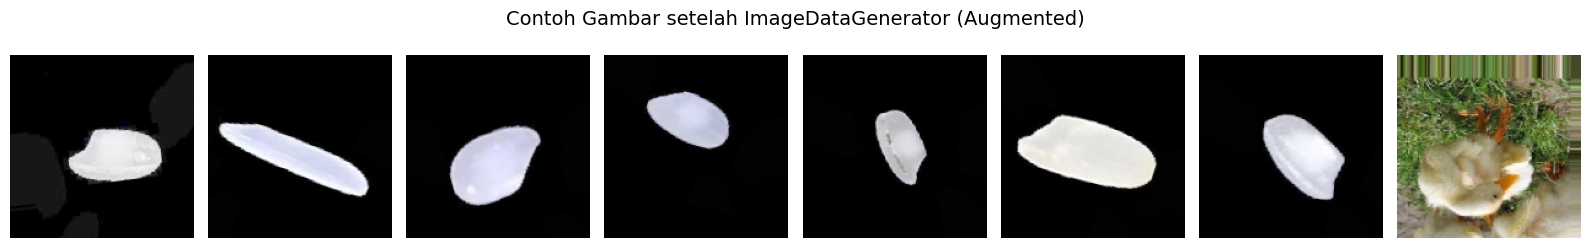

In [33]:
images, labels = next(train_generator)

num_images = 8

plt.figure(figsize=(num_images * 2, 2.5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Contoh Gambar setelah ImageDataGenerator (Augmented)", fontsize=14)
plt.tight_layout()
plt.show()

In [34]:
print("Labels mapping :", train_generator.class_indices)

Labels mapping : {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4, 'Unknown': 5}


## Modelling

In [35]:
# Arsitektur CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745233404.932549      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [36]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,944,326 (26.49 MB)

 Trainable params: 6,944,326 (26.49 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Callback
checkpoint_cb = ModelCheckpoint("saved_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [38]:
# Training Model
EPOCHS = 50

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745233410.950517     181 service.cc:148] XLA service 0x79480c00f860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745233410.951431     181 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745233411.322324     181 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/3587 ━━━━━━━━━━━━━━━━━━━━ 5:14 88ms/step - accuracy: 0.1580 - loss: 1.8335 

I0000 00:00:1745233415.326357     181 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3587/3587 ━━━━━━━━━━━━━━━━━━━━ 604s 166ms/step - accuracy: 0.8321 - loss: 0.4157 - val_accuracy: 0.9781 - val_loss: 0.0634
Epoch 2/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 581s 162ms/step - accuracy: 0.9751 - loss: 0.0753 - val_accuracy: 0.9833 - val_loss: 0.0534
Epoch 3/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 578s 161ms/step - accuracy: 0.9818 - loss: 0.0599 - val_accuracy: 0.9892 - val_loss: 0.0332
Epoch 4/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 582s 162ms/step - accuracy: 0.9831 - loss: 0.0540 - val_accuracy: 0.9850 - val_loss: 0.0527
Epoch 5/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 577s 160ms/step - accuracy: 0.9847 - loss: 0.0536 - val_accuracy: 0.9927 - val_loss: 0.0231
Epoch 6/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 578s 161ms/step - accuracy: 0.9879 - loss: 0.0401 - val_accuracy: 0.9944 - val_loss: 0.0185
Epoch 7/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 578s 161ms/step - accuracy: 0.9886 - loss: 0.0376 - val_accuracy: 0.9945 - val_loss: 0.0171
Epoch 8/50
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 593s 165ms/step - accuracy: 0.9

In [39]:
# Akurasi training dan validation
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Akurasi testing
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"Training Accuracy   : {train_acc * 100:.2f}%")
print(f"Validation Accuracy : {val_acc * 100:.2f}%")
print(f"Testing Accuracy    : {test_acc * 100:.2f}%")

1120/1120 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.9930 - loss: 0.0258
Training Accuracy   : 99.00%
Validation Accuracy : 99.34%
Testing Accuracy    : 99.54%


## Evaluasi dan Visualisasi

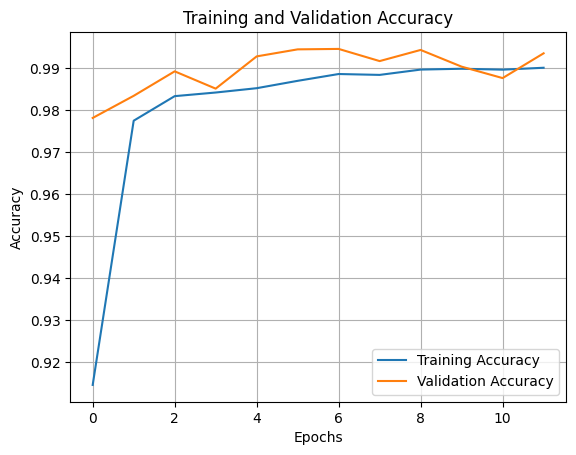

In [40]:
# Plot akurasi pelatihan dan validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Prediksi pada data test
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_labels = np.argmax(y_pred, axis=1)

# True labels dari generator
y_true_labels = test_generator.classes

# Mapping indeks label ke nama kelas
class_labels = list(test_generator.class_indices.keys())

1121/1121 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step


In [51]:
print("=== Classification Report ===")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)

=== Classification Report ===
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      6000
     Basmati       1.00      0.99      0.99      6000
      Ipsala       1.00      1.00      1.00      6000
     Jasmine       0.98      0.99      0.99      6000
   Karacadag       1.00      1.00      1.00      6000
     Unknown       1.00      1.00      1.00      5865

    accuracy                           1.00     35865
   macro avg       1.00      1.00      1.00     35865
weighted avg       1.00      1.00      1.00     35865



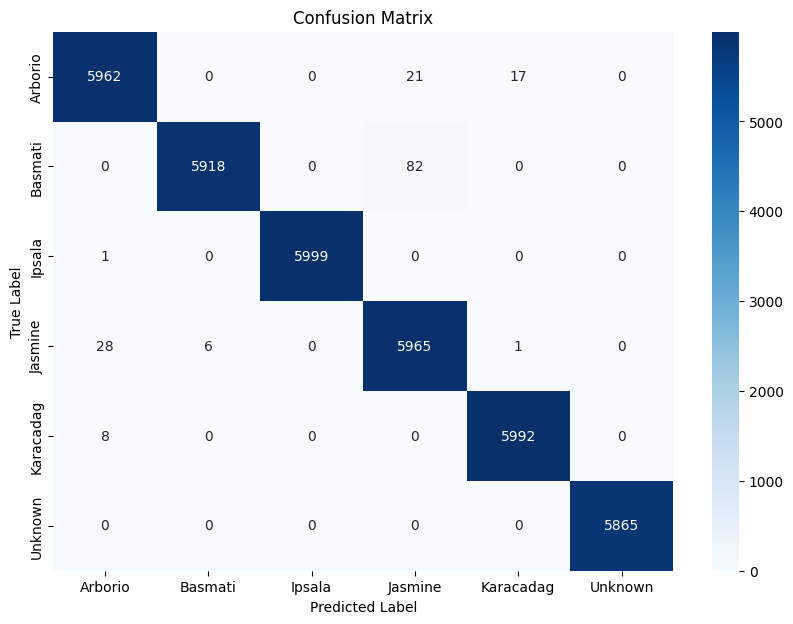

In [52]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Insight**

1. True Label = Arborio
- 5962 sampel diprediksi benar sebagai Arborio
- 21 sampel (1,38% dari 6000) salah diprediksi jadi Jasmine
- 17 sampel (0,28%) salah diprediksi jadi Karacadag
- ** Catatan: Arborio agak mirip bentuknya dengan Jasmine dan Karacadag dalam beberapa kondisi pencahayaan atau sudut, sehingga terjadi sedikit mis labeling.

2. True Label = Basmati
- 5918 sampel benar diklasifikasikan sebagai Basmati
- 82 sampel (1,37%) salah diprediksi jadi Jasmine
- ** Catatan: Tidak ada mis klasifikasi ke Arborio, Ipsala, Karacadag, atau Unknown kesalahan hanya terjadi ke Jasmine, kemungkinan karena kemiripan panjang butir.

3. True Label = Ipsala
- 5999 sampel benar sebagai Ipsala
- 1 sampel (0,02%) salah diprediksi jadi Arborio
- ** Catatan: Hampir sempurna, hanya satu butir yang keliru, mungkin karena ukuran atau sudut foto sangat mirip dengan Arborio.

4. True Label = Jasmine
- 5965 sampel benar sebagai Jasmine
- 28 sampel (0,47%) salah diprediksi jadi Arborio
- 6 sampel (0,10%) salah diprediksi jadi Basmati
- 1 sampel (0,02%) salah diprediksi jadi Karacadag
- ** Catatan: Jasmine mempunyai variasi paling banyak dalam mis klasifikasi karena bentuk agak bulat mirip Arborio dan warna kadang menyerupai Basmati.

5. True Label = Karacadag
- 5992 sampel benar sebagai Karacadag
- 8 sampel (0,13%) salah diprediksi jadi Arborio
- ** Catatan: Karacadag juga kadang tertukar dengan Arborio, mungkin pada gambar yang fokusnya rendah atau warna yang kusam.

6. True Label = Unknown
- 5865 sampel benar diprediksi sebagai Unknown
- 0 sampel terklasifikasi keliru sebagai kelas beras apa pun
- ** Catatan: Model sangat andal mengenali gambar random yang bukan salah satu dari lima jenis beras.

## Konversi Model

In [41]:
SAVE_PATH = '/kaggle/working/Dataset_Klasifikasi_Gambar/'
model.load_weights("saved_model.keras")

SavedModel

In [42]:
saved_model_path = SAVE_PATH + 'saved_model/'
tf.saved_model.save(model, saved_model_path)

MODEL TFJS

In [43]:
tfjs_model_path = SAVE_PATH + 'model_tfjs/'
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    {saved_model_path} \
    {tfjs_model_path}

2025-04-21 13:06:16.585279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745240776.607571     416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745240776.614068     416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1745240782.547122     416 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13699 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1745240783.018907     416 devices.cc:67] Number of eligible GPUs (core co

MODEL TF - LITE

In [44]:
tflite_model_path = SAVE_PATH + 'model_tflite/model.tflite'
os.makedirs(os.path.dirname(tflite_model_path), exist_ok=True)

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

W0000 00:00:1745240788.980662      75 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745240788.980698      75 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745240788.994206      75 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [45]:
# Simpan file TFLite
with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [47]:
labels_path = os.path.join(SAVE_PATH, 'model_tflite/label.txt')
with open(labels_path, 'w') as f:
    for label in classes:
        f.write(f"{label}\n")

print("Kelas yang ditemukan:", classes)

Kelas yang ditemukan: ['Basmati', 'Ipsala', 'Arborio', 'Jasmine', 'Karacadag', 'Unknown']


In [48]:
print(f"Model TensorFlow Lite berhasil disimpan di {tflite_model_path}")
print(f"File label berhasil disimpan di {labels_path}")

Model TensorFlow Lite berhasil disimpan di /kaggle/working/Dataset_Klasifikasi_Gambar/model_tflite/model.tflite
File label berhasil disimpan di /kaggle/working/Dataset_Klasifikasi_Gambar/model_tflite/label.txt


### Daftar semua library Python yang diinstal di lingkungan saat ini

In [49]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.16
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.4
ale-py==0.10.1
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.6.0
arrow==1.3.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.2.10.0.33.26
asttokens==3.0.0
astunparse==1.6.3
atpublic==4.1.0
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.36.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blobfile==3.0.0
blosc2==3.1.0
bokeh==3.6.3
Boruta==0.4.3
boto3==1.37.29
botocore==1.37.29
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_hel

## Inference (Optional)

Repository File : https://github.com/Jejetrs/Dicoding-DBS-Camp-2025---Project-Klasifikasi-Gambar.git

dapat dilihat pada code py yang berisi:
1. index.html
2. app.js
3. style.css
4. Folder model_tfjs

1. Data diluar dataset akan dikenali sebagai data tidak terdefinisi (undefined).

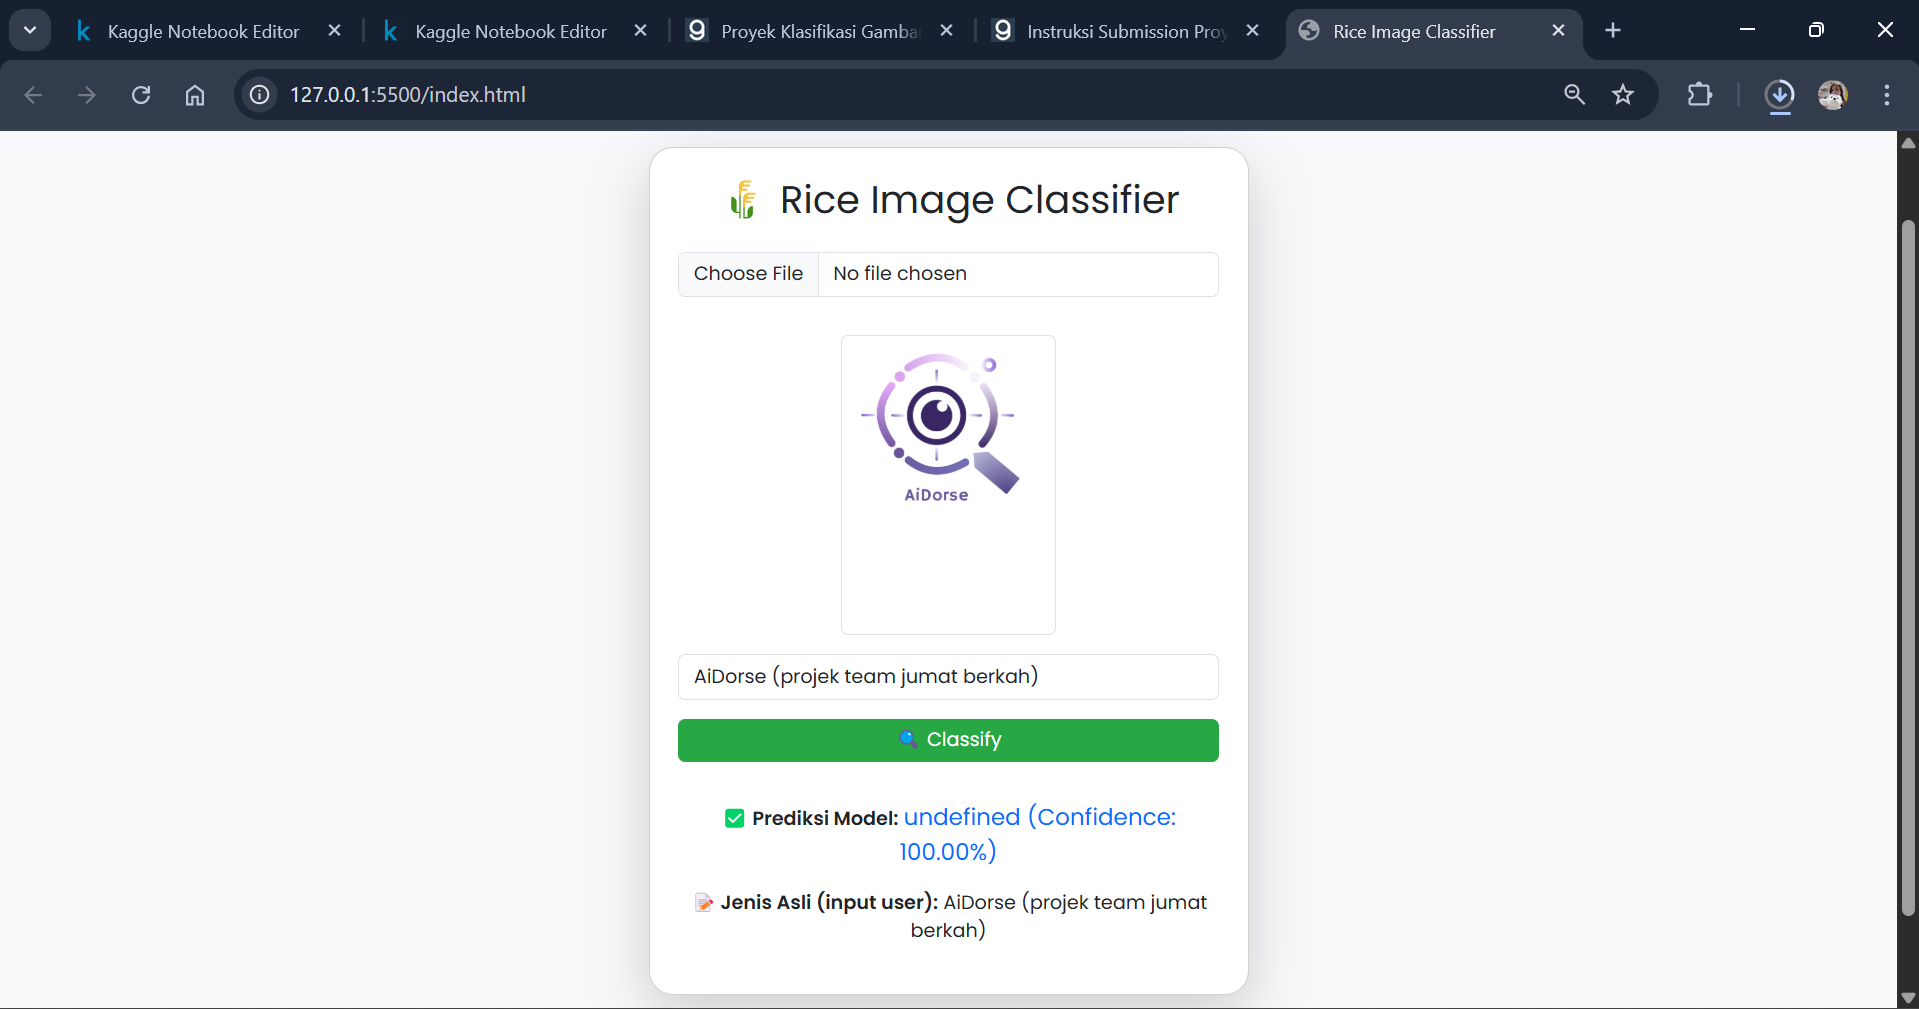

2. Data beras tertentu akan dikenali dengan jenisnya masing - masing.

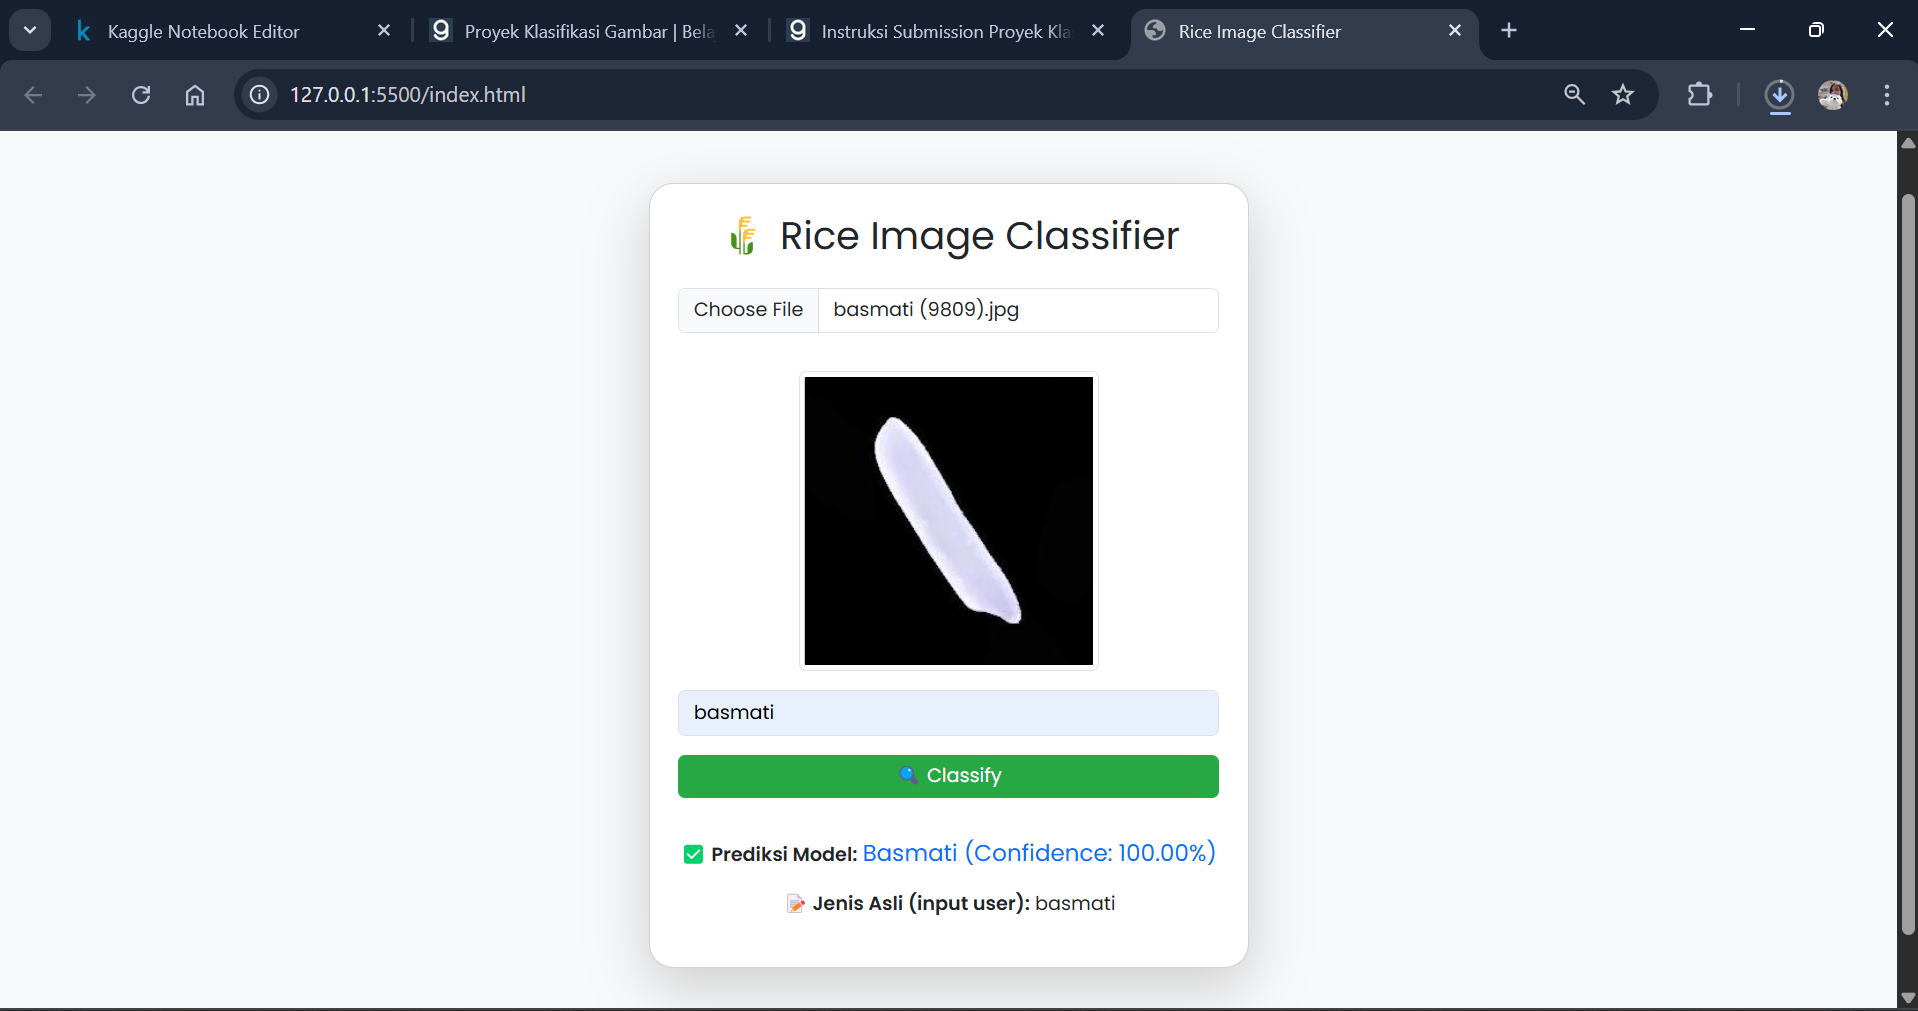

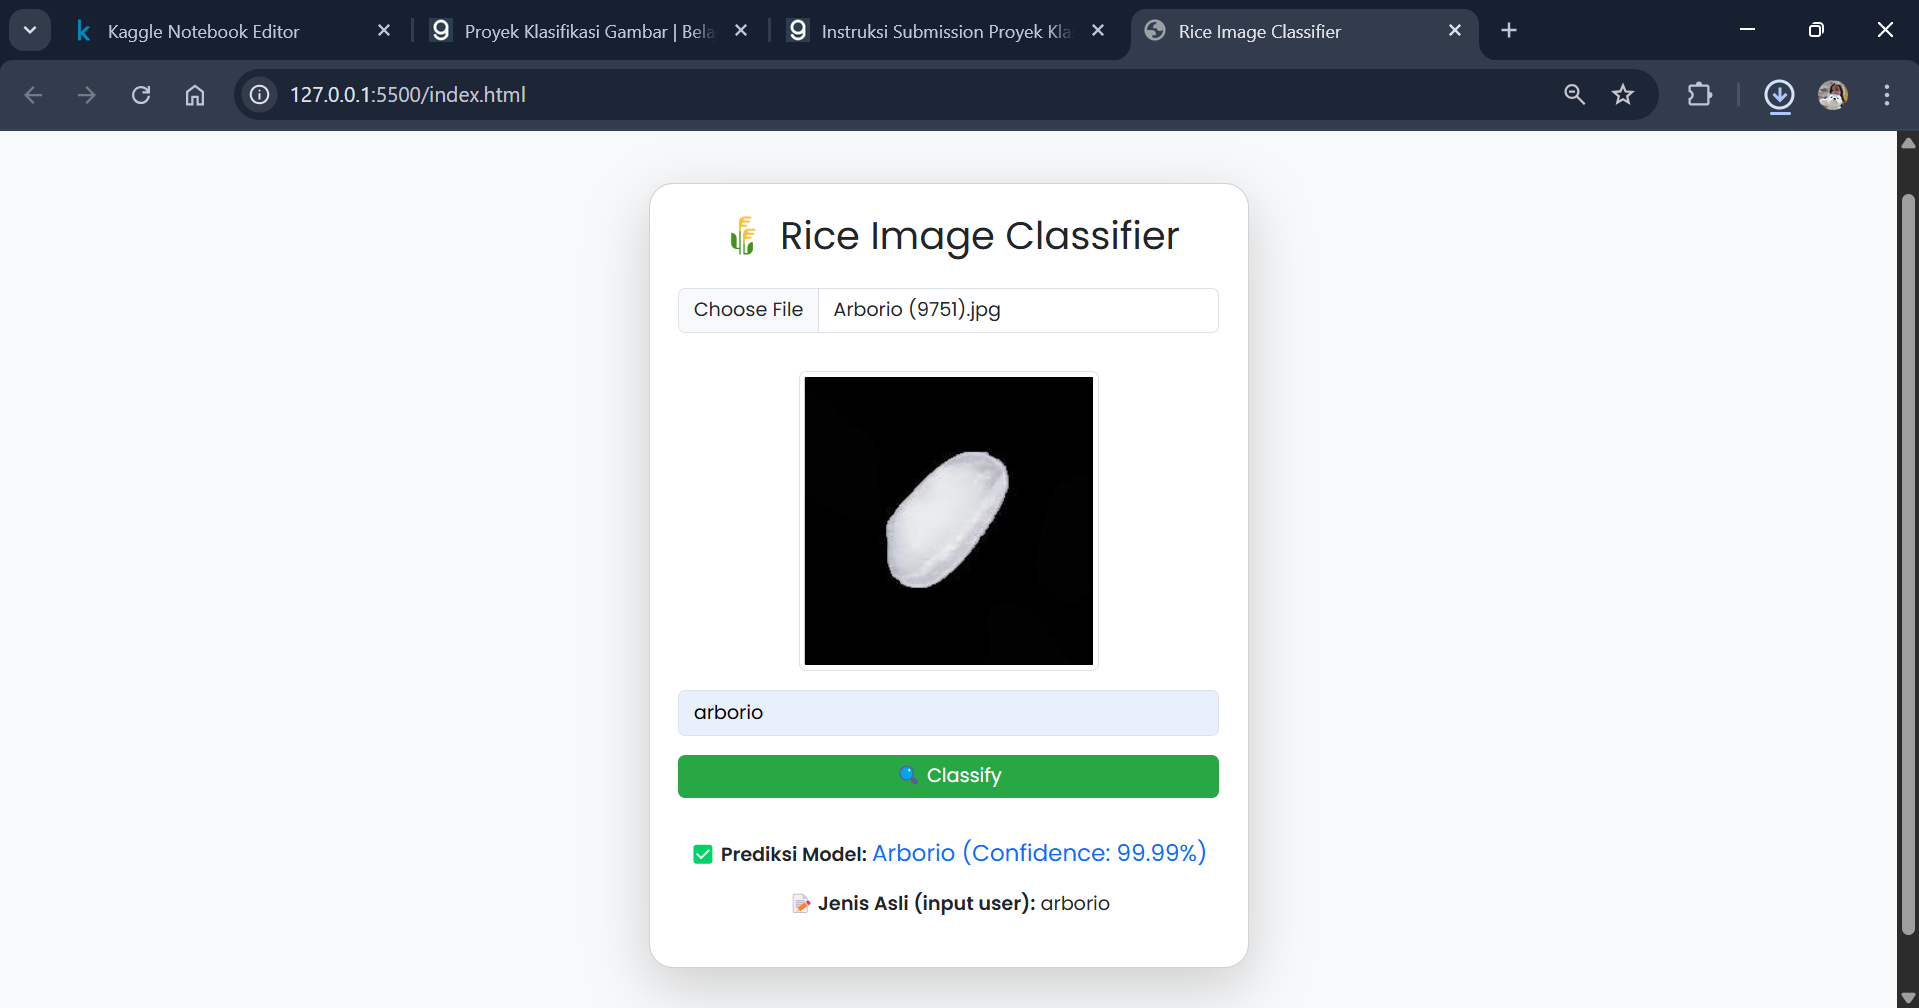

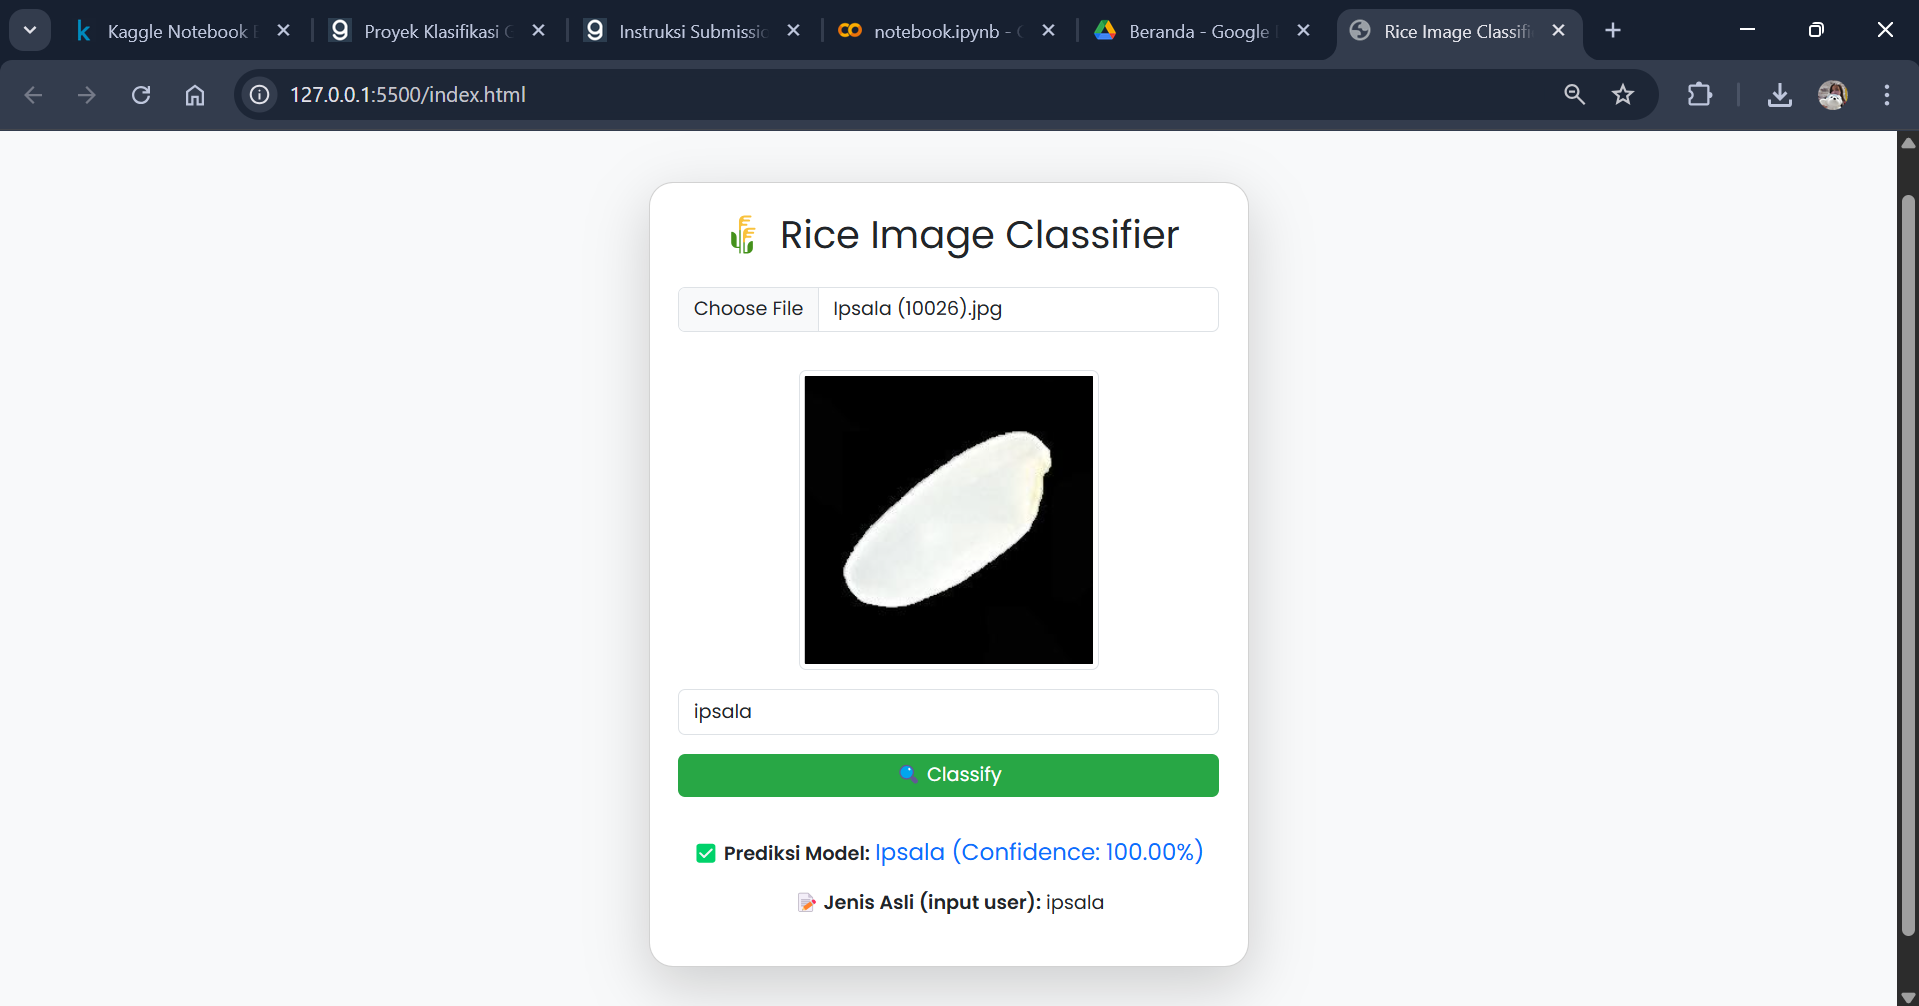

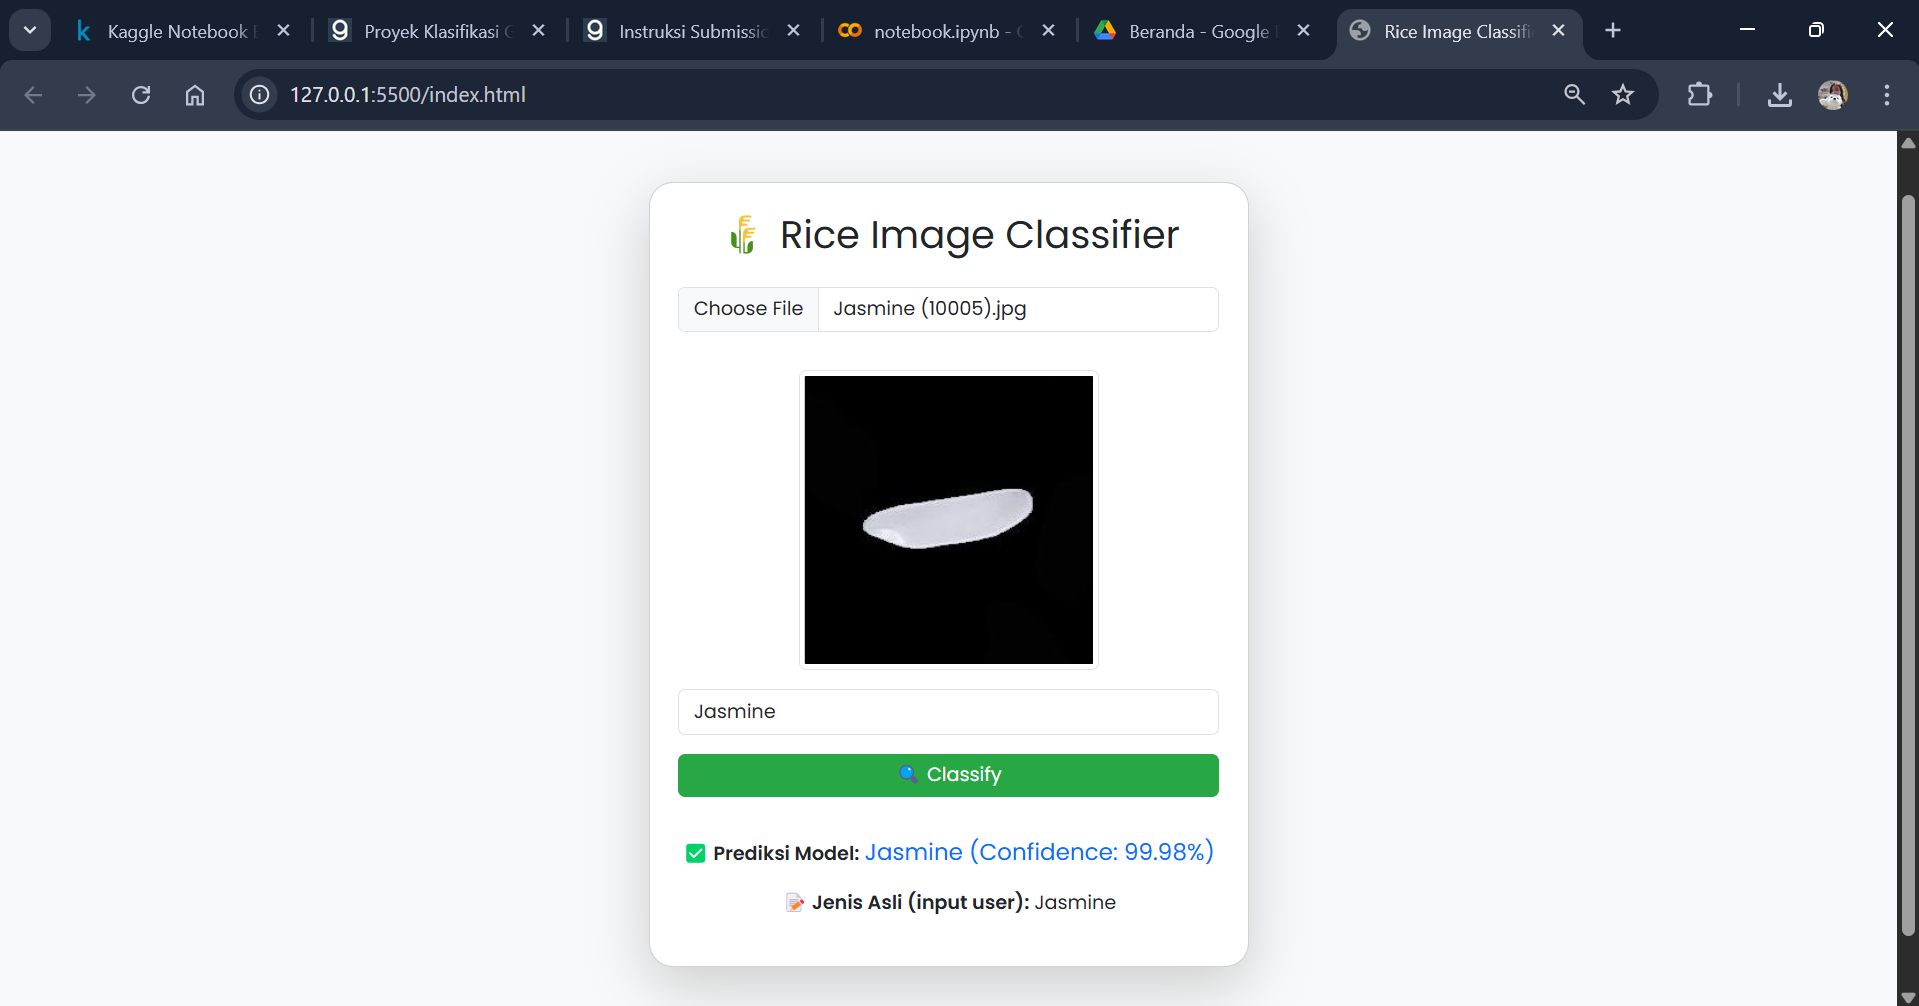

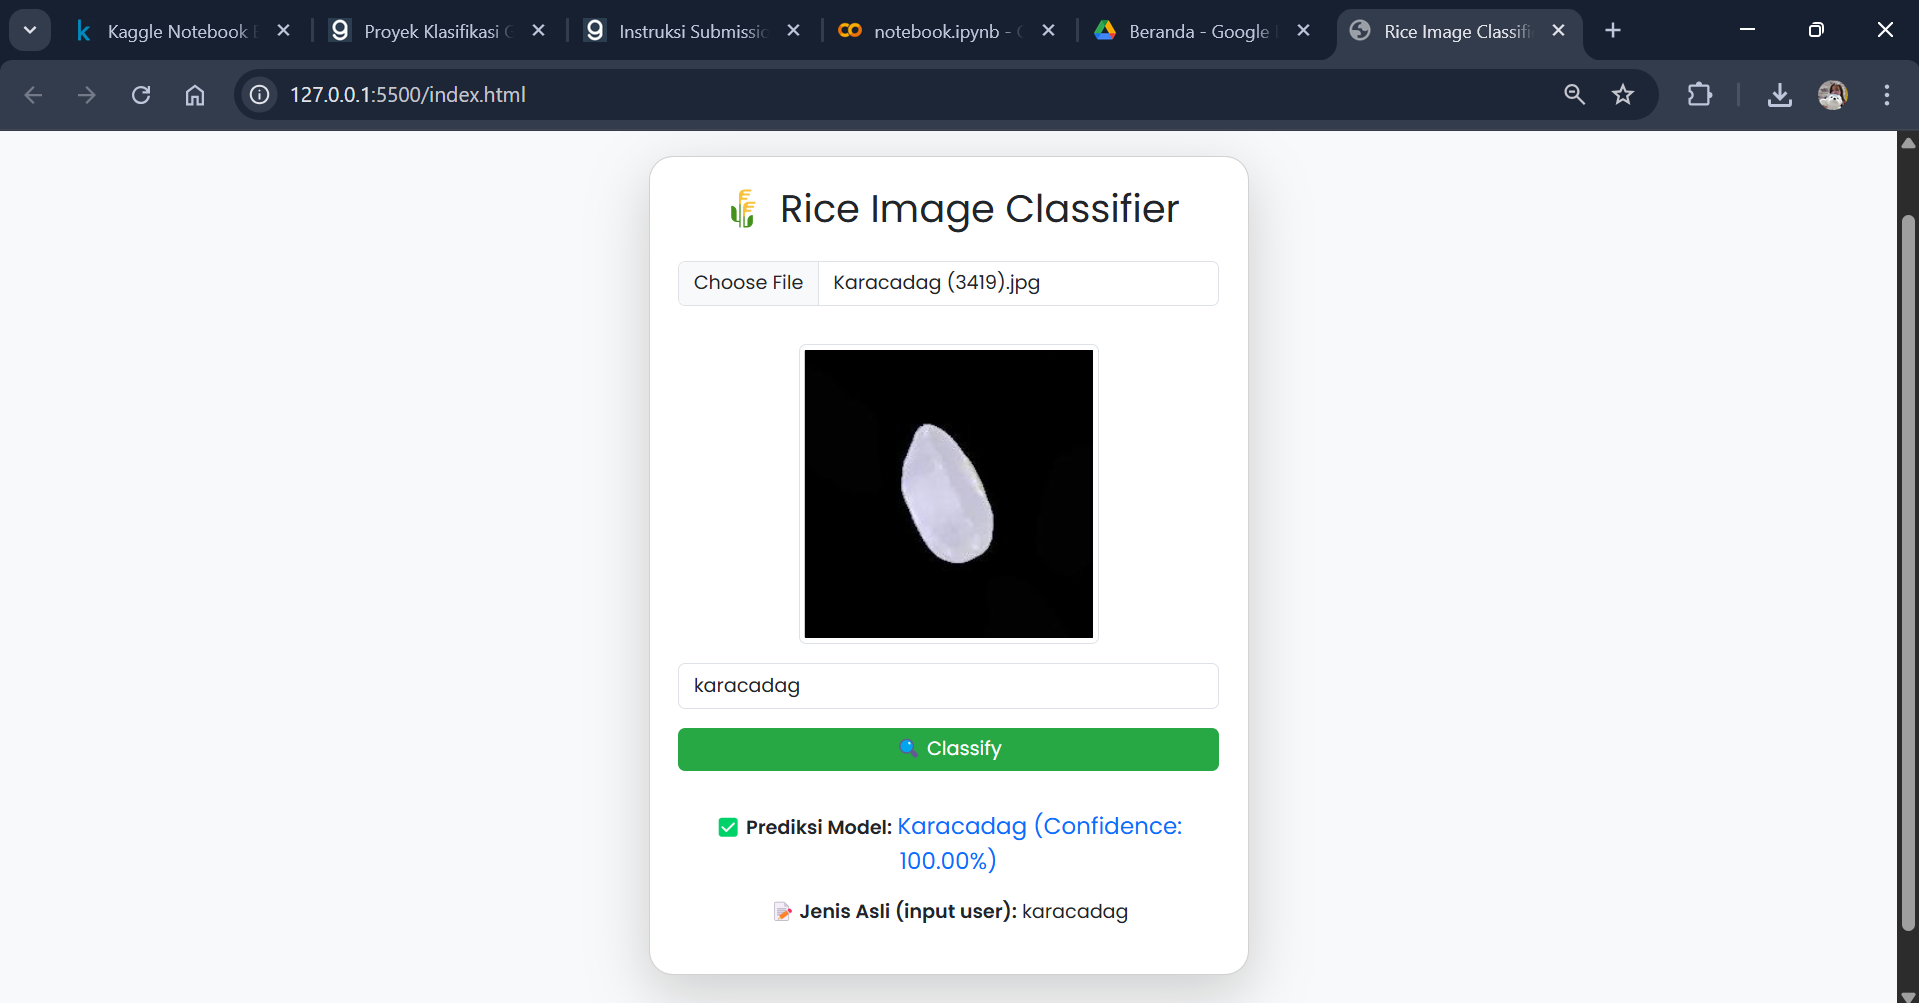

Jika gambar tidak terlihat, bisa diakses melalui link ini :

https://drive.google.com/drive/folders/1A5TdfGCgML7_HK3jXU6xSQG5mFocx6L5?usp=sharing